<a href="https://colab.research.google.com/github/eric-sun92/computer_vision_MNIST/blob/main/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [65]:
# Check for GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [66]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.1+cu118


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

image classification, object detection, facial recognition

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [68]:
from torchvision import datasets 
from torchvision import transforms

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [69]:
img, label = train_data[0]
img.shape, label, len(train_data)


(torch.Size([1, 28, 28]), 5, 60000)

In [70]:
import matplotlib.pyplot as plt


(-0.5, 27.5, 27.5, -0.5)

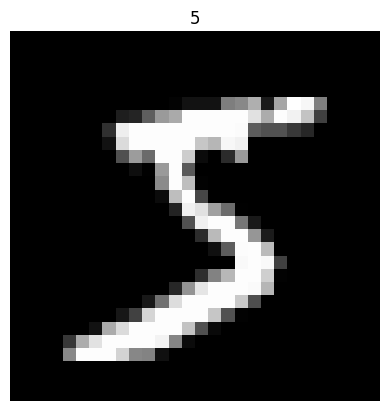

In [71]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis(False)

In [72]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

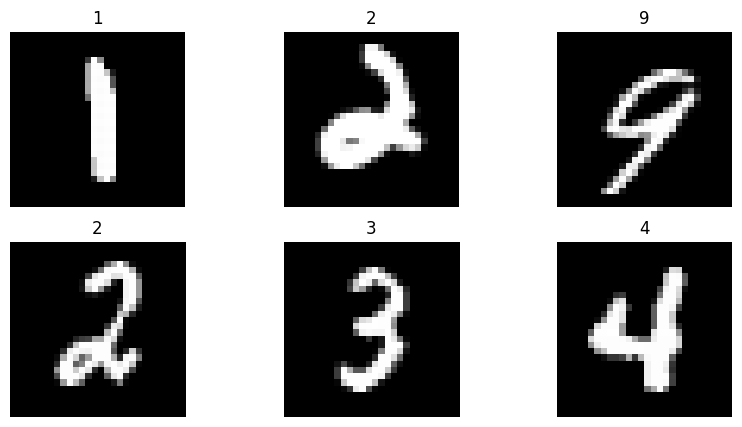

In [73]:
randIdx = torch.randint(0, len(train_data) - 1, size=[6])

fig = plt.figure(figsize=(10, 5))
rows = 2
cols = 3

for i, idx in enumerate(randIdx):
  img, label = train_data[idx]
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(label)
  plt.axis(False)




## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [74]:
from torch.utils.data import DataLoader


In [75]:
BATCH_SIZE = 32

train_dataloader = DataLoader(batch_size=BATCH_SIZE,
                              shuffle=True,
                              dataset=train_data)

test_dataloader = DataLoader(batch_size=BATCH_SIZE,
                              shuffle=False,
                              dataset=test_data)


In [76]:
img, label = next(iter(train_dataloader))
img.shape, label, len(train_dataloader)

(torch.Size([32, 1, 28, 28]),
 tensor([1, 0, 1, 5, 5, 2, 1, 9, 7, 5, 5, 9, 5, 2, 9, 6, 8, 7, 1, 1, 1, 2, 5, 6,
         1, 0, 7, 2, 4, 6, 7, 9]),
 1875)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [77]:
from torch import nn

In [78]:
class MNISTModel(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classification_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=7*7*hidden_units,
                  out_features=out_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classification_block(x)
    return x

In [79]:
torch.manual_seed(42)

model = MNISTModel(in_shape=1, hidden_units=10, out_shape=10).to(device)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [80]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=10)


In [82]:
# Try a dummy forward pass to see what shapes our data is
dummy_x = torch.rand(size=(1, 28, 28)).unsqueeze(dim=0).to(device)
# dummy_x.shape
model(dummy_x)

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], grad_fn=<AddmmBackward0>)

In [83]:
img, label = next(iter(train_dataloader))
print(img.shape)
logits = model(img.to(device))
logits.shape
pred = torch.softmax(logits, dim=1)
pred.shape

torch.Size([32, 1, 28, 28])


torch.Size([32, 10])

In [84]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [85]:
img, label = next(iter(train_dataloader))
img.shape, label

y = model(img.to(device))
y_pred = torch.softmax(y, dim=0).argmax(dim=1)
y_pred.shape


torch.Size([32])

In [86]:
def train_loop(model, data, loss_fn, acc_fn, optimizer, device):
  model.train()
  train_loss, acc = 0, 0
  for batch, (X, y) in enumerate(data):
    X = X.to(device)
    y = y.to(device)

    y_logits = model(X)

    y_preds = torch.softmax(y_logits, dim=0).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    train_loss += loss
    acc += acc_fn(y_preds.cpu(), y.cpu())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} out of {len(data.dataset)} samples")

  train_loss /= len(data)
  acc /= len(data)

  print(f"loss: {train_loss:.5f}, acc: {acc:.2f}")

def test_loop(model, data, loss_fn, acc_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for (X, y) in data:

      X = X.to(device)
      y = y.to(device)

      y_test_logits = model(X)
      y_test_preds = torch.softmax(y_test_logits, dim=0).argmax(dim=1)

      test_loss += loss_fn(y_test_logits, y)
      test_acc += acc_fn(y_test_preds.cpu(), y.cpu())
    
    test_loss /= len(data)
    test_acc /= len(data)

    print(f"testLoss: {test_loss:.5f}, testAcc: {test_acc:.2f}")

epochs = 5
start_time = timer()

for epoch in tqdm(range(epochs)):
  train_loop(model, train_dataloader, loss_fn, acc_fn, optimizer=optimizer, device=device)
  test_loop(model, test_dataloader, loss_fn, acc_fn, device)

end_time = timer()

total_time = end_time - start_time
print(f"total runtime: {total_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.27225, acc: 0.81
testLoss: 0.06792, testAcc: 0.91
Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.07094, acc: 0.88
testLoss: 0.04614, testAcc: 0.92
Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.05474, acc: 0.88
testLoss: 0.04239, testAcc: 0.93
Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.04636, acc: 0.89
testLoss: 0.04535, testAcc: 0.92
Looked at 0 out of 60000 samples
Looked at 1

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

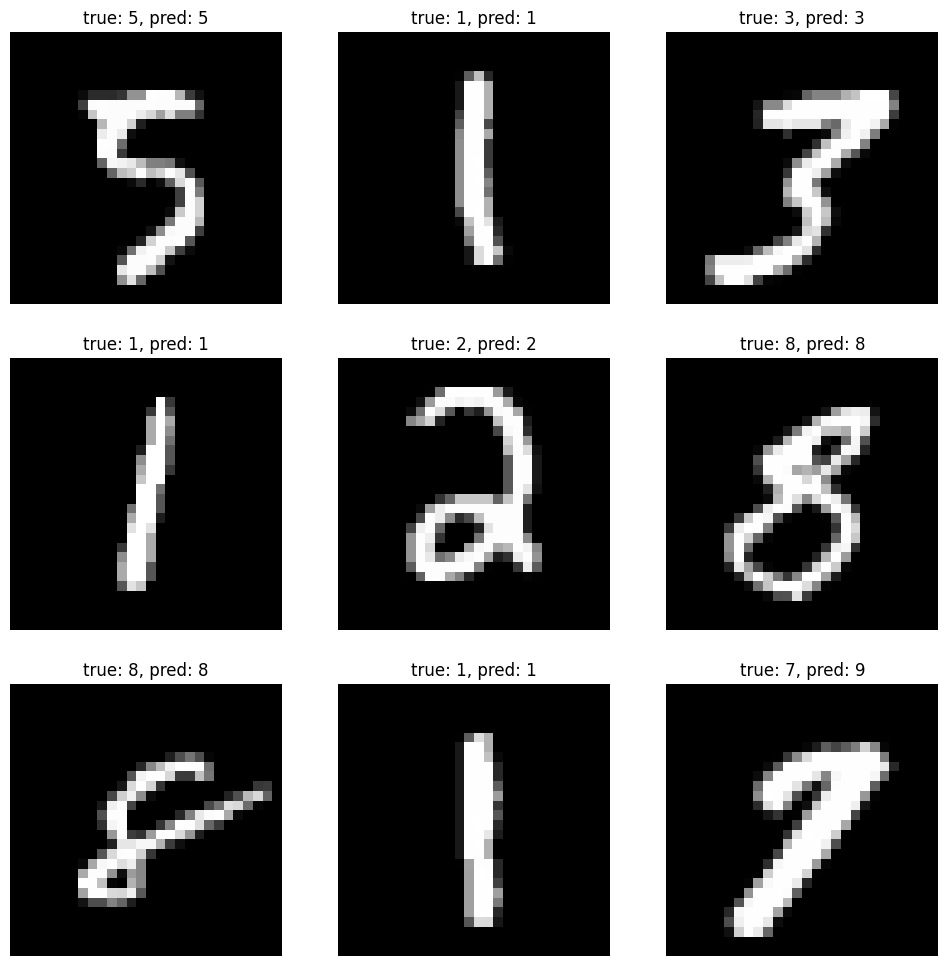

In [87]:
# torch.manual_seed(42)
randIdx = torch.randint(0, len(test_data) - 1, size=[9])

fig = plt.figure(figsize=(12, 12))
rows = 3
cols = 3
model.eval()
with torch.inference_mode():
  for i, idx in enumerate(randIdx):
    image, label = test_data[idx]
    logit = model(image.unsqueeze(dim=0).to(device))
    pred = torch.softmax(logit, dim=1).argmax(dim=1)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"true: {label}, pred: {pred[0].item()}")
    plt.axis(False)


In [88]:
image, label = test_data[43]
label
print(image.unsqueeze(dim=0).shape)
logit = model(image.unsqueeze(dim=0).to(device))
print(logit.shape)
logit
pred = torch.softmax(logit, dim=1)
pred
# pred[0].item()

torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


tensor([[2.7660e-10, 6.1528e-05, 9.9993e-01, 2.3333e-06, 4.6821e-06, 1.5609e-10,
         2.8059e-07, 2.1883e-07, 1.9545e-08, 3.3909e-12]],
       grad_fn=<SoftmaxBackward0>)

In [89]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "MNNIST_Model.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

print(f"saved model to {MODEL_SAVE_PATH}")


saved model to models/MNNIST_Model.pth


In [90]:
# load model

loadedModel = MNISTModel(1, 10, 10)

loadedModel.load_state_dict(torch.load(MODEL_SAVE_PATH))

loadedModel = loadedModel.to(device)
loadedModel

MNISTModel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [91]:
pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
y_preds = []
loadedModel.eval()
with torch.inference_mode():
  for sample, label in test_dataloader:
    y_logit = loadedModel(sample)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_preds_tensor = torch.cat(y_preds)
y_preds_tensor.shape

torch.Size([10000])

In [93]:
img, label = next(iter(test_dataloader))
img.shape

torch.Size([32, 1, 28, 28])

0.14.0


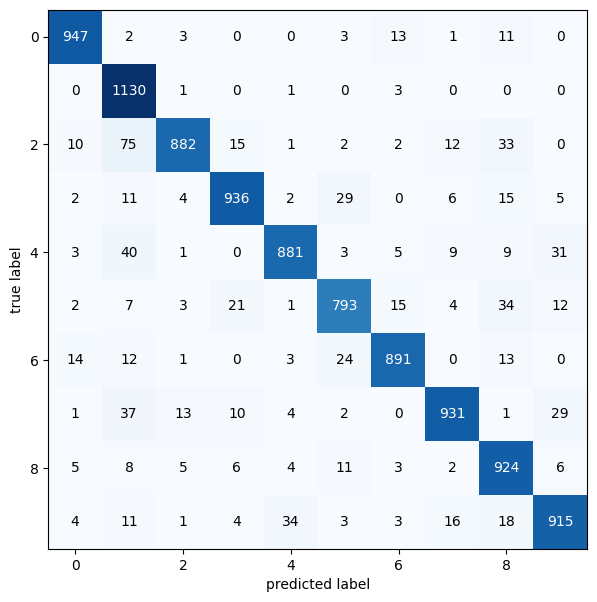

In [94]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

print(mlxtend.__version__)

confmat = ConfusionMatrix(task="multiclass",
                          num_classes=10)

confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    figsize=(10, 7),
    
    )

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [95]:
randTensor = torch.rand(1, 3, 64, 64)
randTensor.shape

conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10,
                       kernel_size=3,
                       padding=1,
                       stride=1)

y = conv_layer(randTensor)
y.shape

torch.Size([1, 10, 64, 64])

## 13. Use a model similar to the trained `model_2` from notebook 03 to make 
predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [96]:
# 13. Use a model similar to the trained model_2 from notebook 03 to make predictions on the test torchvision.datasets.FashionMNIST dataset.
# Then plot some predictions where the model was wrong alongside what the label of the image should've been.
# After visualing these predictions do you think it's more of a modelling error or a data error?
# As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?


In [101]:
import torchvision

fashion_train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

fashion_test_dataset = datasets.FashionMNIST(
    train=True,
    root="data",
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

fashion_train_dataloader = DataLoader(batch_size=BATCH_SIZE, 
                                      shuffle=True,
                                      dataset=fashion_train_dataset)

fashion_test_dataloader = DataLoader(batch_size=BATCH_SIZE, 
                                      shuffle=True,
                                      dataset=fashion_test_dataset)

fashion_model = MNISTModel(1, 10, 10).to(device)

fashion_loss_fn = nn.CrossEntropyLoss()
fashion_optimizer = torch.optim.SGD(fashion_model.parameters(), 0.1)

for epoch in tqdm(range(4)):
  train_loop(fashion_model, fashion_train_dataloader, fashion_loss_fn, acc_fn, fashion_optimizer, device)
  test_loop(fashion_model, fashion_test_dataloader, fashion_loss_fn, acc_fn, device)



100%|██████████| 26421880/26421880 [00:14<00:00, 1781642.81it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 117964.49it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2204531.18it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12338444.00it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4 [00:00<?, ?it/s]

Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.59880, acc: 0.75
testLoss: 0.36122, testAcc: 0.80
Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.34516, acc: 0.81
testLoss: 0.30347, testAcc: 0.82
Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.31015, acc: 0.82
testLoss: 0.28583, testAcc: 0.82
Looked at 0 out of 60000 samples
Looked at 12800 out of 60000 samples
Looked at 25600 out of 60000 samples
Looked at 38400 out of 60000 samples
Looked at 51200 out of 60000 samples
loss: 0.28881, acc: 0.82
testLoss: 0.26579, testAcc: 0.83


In [146]:
img, label = fashion_test_dataset[4]
img.shape

logit = fashion_model(img.unsqueeze(dim=0))
print(logit)
pred = torch.softmax(logit.squeeze(), dim=0).argmax(dim=0)
pred.item()

tensor([[ 4.3262,  4.9864, -5.0404,  5.2212,  1.6681, -4.9351,  6.6154, -4.1319,
         -1.0846, -7.9613]], grad_fn=<AddmmBackward0>)


6

In [149]:
fashion_model.train()
incorrect_indexes = []
with torch.inference_mode():
  for idx, (img, label) in tqdm(enumerate(fashion_test_dataset)):
    y_logit = fashion_model(img.unsqueeze(dim=0))
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=0).item()
    if y_pred != label:
      incorrect_indexes.append(idx)


0it [00:00, ?it/s]

In [150]:
len(incorrect_indexes)

5769

In [158]:
fashion_classes = fashion_train_dataset.classes
fashion_classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

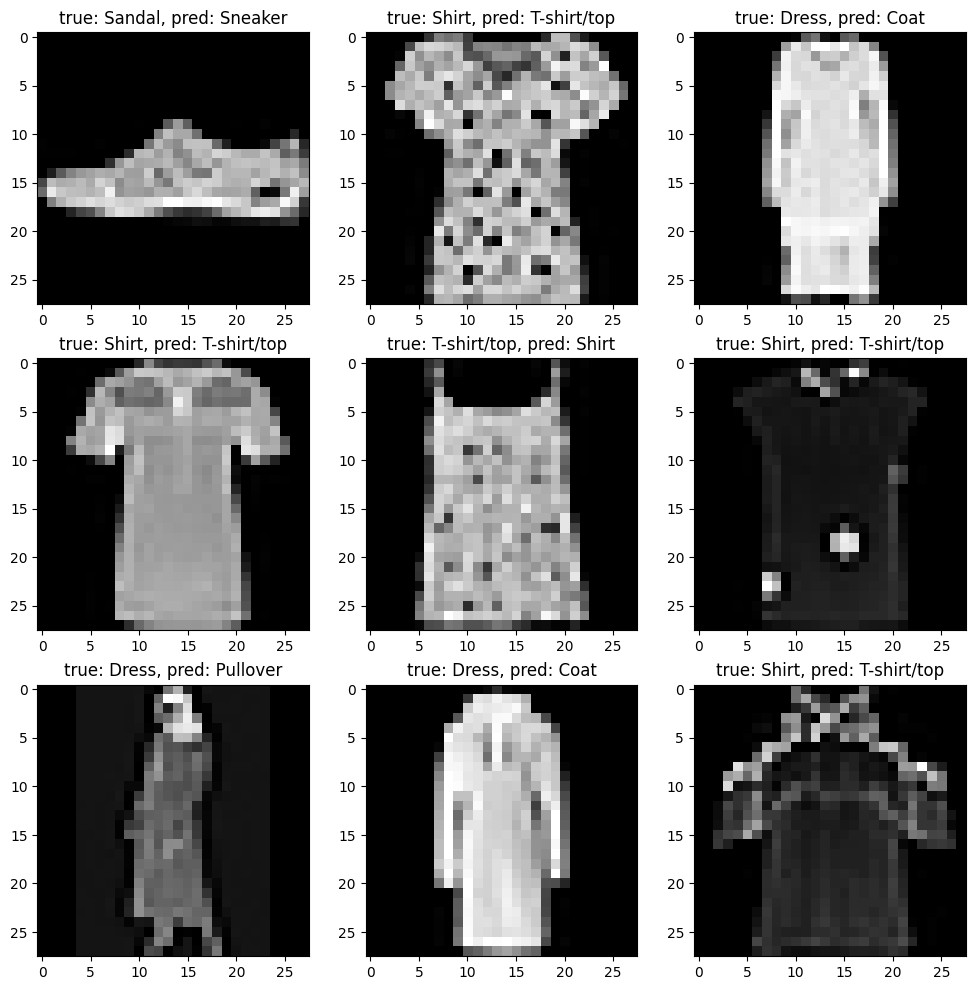

In [159]:
fig = plt.figure(figsize=(12, 12))
rows, cols = 3, 3
for i in range(1, 10):
  randIndex = torch.randint(0, len(incorrect_indexes), size=[1])
  target_idx = incorrect_indexes[randIndex]
  img, label = fashion_test_dataset[target_idx]

  fashion_model.train()
  with torch.inference_mode():
    logit = fashion_model(img.unsqueeze(dim=0))
    y_pred = torch.softmax(logit.squeeze(), dim=0).argmax(dim=0).item()

  plt.subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"true: {fashion_classes[label]}, pred: {fashion_classes[y_pred]}")



In [160]:
# save the fashion model

FASHION_MODEL_PATH = "FashionMNISTModel.pth"
FASHION_SAVE_MODEL_PATH = MODEL_PATH / FASHION_MODEL_PATH

torch.save(obj=fashion_model.state_dict(),
           f=FASHION_SAVE_MODEL_PATH)


In [163]:
from torchvision.datasets.mnist import FashionMNIST
# load it back up

loaded_fashion_model = MNISTModel(1, 10, 10)
loaded_fashion_model.load_state_dict(torch.load(FASHION_SAVE_MODEL_PATH))

loaded_fashion_model.state_dict()

OrderedDict([('conv_block1.0.weight',
              tensor([[[[ 0.2361, -0.1042, -0.3516],
                        [ 0.1742, -0.1793, -0.3823],
                        [-0.4919, -0.2142, -0.3674]]],
              
              
                      [[[ 0.6093, -0.5098, -0.0013],
                        [ 0.7442, -0.4552, -0.4774],
                        [ 0.7214,  0.0756, -0.5189]]],
              
              
                      [[[-0.0035,  0.2076,  0.1936],
                        [-0.7763,  0.3958,  0.4726],
                        [-0.5186, -0.1268,  0.1902]]],
              
              
                      [[[-0.9359, -0.3483,  0.2166],
                        [-1.1445, -0.3528,  0.0809],
                        [ 0.0145,  0.6235, -0.0376]]],
              
              
                      [[[ 0.7758,  0.1146, -0.1547],
                        [ 0.5860,  0.2732, -0.3656],
                        [-0.2908, -0.4915, -0.6240]]],
              
              
       